In [27]:
import numpy as np
from scipy import stats 
from scipy.stats import norm
from scipy import integrate
from functools import partial
import matplotlib.pyplot as plt

In [32]:
class Gaussian:
    def __init__(self, rho, Law_RS, Law_RF):
        self.rho = rho     # Dependence Parameter
        self.Law_RS = Law_RS   # Marginal Distribution of Spot
        self.Law_RF = Law_RF   # Marginal Distribution of Future
        
    def H(self, w, h, r_h): # a helper function to compute the input to F_RF
        A = self.Law_RS.ppf(w) - r_h
        if h!=0:
            B = h
        else:
            B = 0.00001
        return A/B
    
    def g(self, w, h, r_h):
        return self.Law_RF.cdf(self.H(w=w, h=h, r_h=r_h))
    
    def D1C(self, w, h, r_h):
        a = self.phi(w) + self.phi(self.g(w,h,r_h))
        A = self.d_phi_inverse(a)
        B = self.d_phi(w)
        return A*B

    def D1C(self, w, rho, h, r_h):
        part1 = 1/(2*np.pi*self.rho)
        q = norm.ppf(w)
        part2a = -1/(2-2*self.rho**2)
        part2b = lambda y: q**2 - 2*self.rho*q*y + y**2
        part2_int  = lambda y: np.exp(part2a * part2b(y))
        part2 = integrate.quad(part2_int, -np.inf, norm.ppf(self.g(w, h, r_h)))[0]
        part3 = 1/norm.pdf(norm.ppf(w))    
        return part1 * part2 * part3
            
    def F_RH(self, h, r_h):
        func = partial(self.D1C, h=h, r_h=r_h, rho=rho)
        I = integrate.quad(func, 0.0001, 0.999)
        return 1 - I[0] # - self.theta*I[0] # CORRECTION: theta times the Integral

In [47]:
# Marginals
Law_RS = stats.norm(loc=0, scale=1)
Law_RF = stats.norm(loc=0, scale=1)

# Parameters
h=1
rho_arr = [0.001, 0.01, 0.1, 0.5]
y_arr = []

for rho in rho_arr:
    c = Gaussian(rho = rho, # tau = 1/theta, meaning tau% chance of concordance
               Law_RS = Law_RS,
               Law_RF = Law_RF)

    x  = np.linspace(-5,5,10)
    y  = [c.F_RH(h=h, r_h=i) for i in x]
    y_arr.append(y)
print("y is done")

y is done


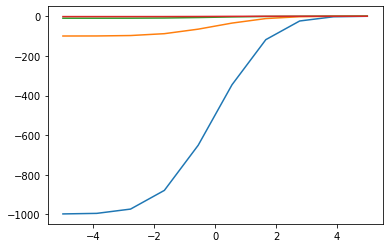

In [48]:
for y in y_arr:
    plt.plot(x, y)
# plt.plot(x, )

In [50]:
y

[-0.730145103705498,
 -0.7300608503576429,
 -0.7254368403535758,
 -0.6474811199180945,
 -0.22931043188592626,
 0.5005528916852462,
 0.918103402707923,
 0.9954433375364589,
 0.9999231650515455,
 0.9999996445052832]